### Ensemble Models
here I will experiment with random forest models. I will use the simpler sklearn random forest, train it on PCA and unprocessed data, then I will use an XGboost model on PCA and unprocessed data. I'm scrapping the standardized data in this section because we learned from the logistic regression that standardized data doesn't provide much if any help in algorithms that don't use distance based calculations (i.e. PCA, KNN's). + random forests don't typical require feature scaling, so again training on standardized data (in this case) will only provide marginal differences in outcome.

*Bonus: train on standardized data anyways to confirm or deny hypothesis*

#### Sklearn Random Forest Classifier 

**PCA projected data (+ standardized)**
- My first attempt with the random forest resulted in a severely overfit model, train accuracy was *100%* while test accuracy was *21.43%*. I will try to tune it to at least not overfit so much.
- I believe overfitting was mitigated by capping the max_depth hyperparameter. I settled with the value *8*. The model still did poorly on this data with train accuracy of *32.71%* and a test accuracy of *25.17%*
- judging from the confusion matrix, the model rarely predicted class 3

**Unprocessed data**
- training of course was much longer, but the score was better relative to PCA, on the first go I ended up with an overfitted forest that scored a train accuracy of *99%* and test accuracy of *42.75%*
- after increasing n_estimators from 100 to 200 capping max_depth to *10*, and two other hyperparameter changes, I got a train accuracy of *81.38%* and test accuracy *41.17%*. Although I wasn't able to reduce overfitting as much as I would've liked, I was able to at least minimize it a little while maintaining almost the same test accuracy. If I had time I would've tried to reduce overfitting even more, but fitting took around 3+ minutes each time. Which adds up.

#### XGBoost Classifier

**PCA projected data (+ standardized)**
- The out of the box (OOB) XGBoost model resulted in *60.22%* train accuracy and *22.20%* test accuracy. I wasn't surprised that it did this poorly as we already know the PCA data doesn't capture all the proper information (and these models aren't suited for image data), but I was a bit suprised that the model didn't overfit to the data as much as the first attempt sklearn random forest (first experiment in this notebook). 
- after adjusting/restricting the n_estimators and max_depth, I was able to minimize overfitting and get a (slightly) better accuracy. My train accuracy was *30.51%* and the test accuracy was *25.32%*. I would argue this amount of 'overfitting' isn't even overfitting at all. 
- from confusion matrix again, class 3 was rarely predicted, and class 8 had the most correct predictions. Comparing this confusion matrix to the first experiment in the notebook, I see many similarities.

**Unprocessed data**
- Funny enough when I tried to train a model with n_estimators=8 it kept erroring. I believe the issue was simply due to hardware constraints on my machine. I only trained a model with n_estimators=5 and max_depth=5 to keep cpu/memory usage low enough to train locally and ended up getting a train accuracy of *56.19%* and test acccuracy of *38.40%*.
- I moved my model code to Google colab and used n_estimators=12  and max_depth=8  yielding a train accuracy of *96.92%* and a test accuracy of *42.60%*.. severely overfit, and training time on Colab took about 9 minutes as well, my longest training session yet.
-  Finally, using a model with n_estimators=12 and max_depth=5, I had a train accuracy of *68.79%* and a test accuracy of *41.60%* I would consider this a success relative to all my other attempts with ensembles because I was able to reduce overfitting even more than I previously did with SKlearn's random forest model while retaining a *somewhat* equal test accuracy. I will admit the model is still overfit, but I believe I have the skill to reduce that even further if I spent more time on it.

*Tenochtitlan* (unprocessed data)
- I ended up getting a gaming pc and set it up as my home server, running jupyter lab on it.

command: `jupyter lab --no-browser --ip=100.109.213.114 --port=8080 > logs/jupyter.log 2>&1 &`

- I found that it was remarkably faster than running these XGBoost models on my surface book AND colab (I guess bc I was running on colab's cpu). Anyways I trained an XGBoost model with features:<br>
`n_estimators=15`, `max_depth=6`

- This would've errored out on my surface book (idk yet abt my lenovo) and taking 10+ minutes (perhaps even time out) on colab (since gpu's aren't used for these models or at least I didn't try).<br>
`train accuracy: 86.19%`<br>
`test accuracy: 43.73%`


### ~~Randomized CV Search~~
Here I will use my best model and perform a randomized cross validation search across a hyperparameter space to find the best hyperparameters


### Conclusion
I believe I'll cut the experiment here when it comes to ensemble models and classical models as well. I think my time is better suited to try and build a CNN since this is image data anyways. This approach with classical models was mostly to 
- refresh my memory on ML workflows, concepts, and basic model tuning/pipelines
- Implement PCA, see it in action, and apply that transformation technique on a real dataset
- rework with some important models to get a basic idea of how they perform and visualize their outcomes

In the future what I would like to do better is:
- have a more thorough approach on how I log my experiments and their outcomes
- Take a deeper dive into class specific metrics (recall, F1, precision)
- have a better plan for models that take actual time, cpu, and memory to train (instead of just moving that one experiment to Colab)
- implement grid search or randomized cv search to search a variety of hyperparameters spaces on at least one model so it ends up performing better.
- be better at recording what I learned, what I don't understand, and what I want to understand.


In [1]:
import pandas
import seaborn as sns
from sklearn.datasets import fetch_openml
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

In [2]:
# fetch & prep all the data
X, y = fetch_openml('CIFAR_10_small', as_frame=True, return_X_y=True, parser='auto')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=27)

# standardize + pca
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)    # 'fit' a standardization for the train data so no test mean and std leaks to model
X_test_std = scaler.transform(X_test)
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_std)   # decompose principal components from training data
X_test_pca = pca.transform(X_test_std) 

#### Sklearn Random Forest Classifier

In [3]:
sk_rf = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=8, min_samples_split=4, 
                               min_samples_leaf=2)
'''
n_estimators = the number of trees in the forest
criterion = determines how splits are chosen within trees... gini is usually fine

max_depth = The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure 
or until all leaves contain less than min_samples_split samples... try 10, 20, 30, or whatever...
Shallow trees (low max depth) reduce the risk of overfitting but may underfit the data. 
Deep trees (high max depth) capture more intricate patterns but can lead to overfitting.

min_samples_split = The minimum number of samples required in a node for it to be split... default is 2
Higher values prevent trees from splitting too deep, reducing the risk of overfitting. 
Lower values can result in more complex trees, possibly leading to overfitting.

min_samples_leaf = minimum number of samples required to be at a leaf node default is 1
'''

sk_rf.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=250)

In [33]:
# metrics
labels = [str(x) for x in range(10)]

y_pred_train_pca = sk_rf.predict_proba(X_train_pca)
loss = log_loss(y_train, y_pred_train_pca, labels = labels)
print(f'Train loss for sklearn random forest on PCA data is {loss:.3f}')

y_pred_train_pca = sk_rf.predict(X_train_pca)
acc = accuracy_score(y_train, y_pred_train_pca, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test_pca = sk_rf.predict_proba(X_test_pca)
loss = log_loss(y_test, y_pred_test_pca, labels = labels)
print(f'Test loss for sklearn random forest on PCA data is {loss:.3f}')

y_pred_test_pca = sk_rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred_test_pca, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Train loss for sklearn random forest on PCA data is 1.895
Accuracy for the train data is 32.71%
Test loss for sklearn random forest on PCA data is 2.063
Accuracy for the test data is 25.17%


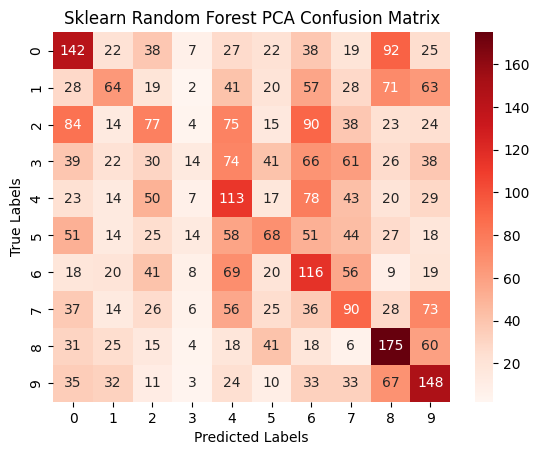

In [34]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test_pca)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Sklearn Random Forest PCA Confusion Matrix")
plt.show()

In [56]:
sk_rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10, min_samples_split=3, 
                               min_samples_leaf=2)
sk_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200)

In [57]:
# metrics
labels = [str(x) for x in range(10)]

y_pred_train = sk_rf.predict_proba(X_train)
loss = log_loss(y_train, y_pred_train, labels = labels)
print(f'Train loss for sklearn random forest on unprocessed data is {loss:.3f}')

y_pred_train = sk_rf.predict(X_train)
acc = accuracy_score(y_train, y_pred_train, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test = sk_rf.predict_proba(X_test)
loss = log_loss(y_test, y_pred_test, labels = labels)
print(f'Test loss for sklearn random forest on unprocessed data is {loss:.3f}')

y_pred_test = sk_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_test, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Train loss for sklearn random forest on unprocessed data is 1.260
Accuracy for the train data is 81.38%
Test loss for sklearn random forest on unprocessed data is 1.775
Accuracy for the test data is 41.17%


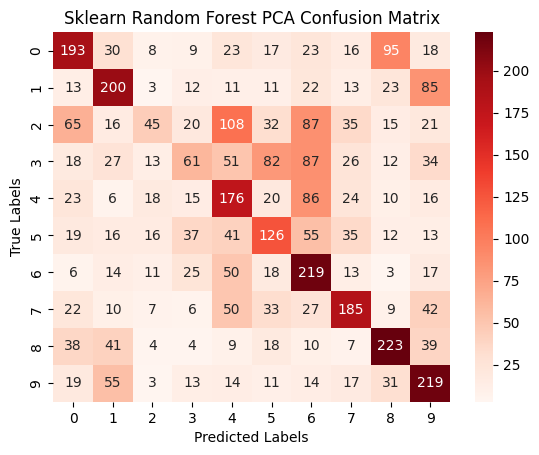

In [58]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Sklearn Random Forest Confusion Matrix")
plt.show()

#### XGBoost Classifier

In [4]:
# encoding the labels there is no error throw from .fit
le = LabelEncoder()
y_train_new = le.fit_transform(y_train)
# y_train_new = np.asarray(y_train, dtype='int64')

# this is also a way to fix that issue ^
# y_test_new = np.asarray(y_test, dtype='int64')
y_test_new = le.transform(y_test)


rf = XGBClassifier(n_estimators=12, max_depth=5)
'''
n_estimators = number of trees, but in xtreme gradient boosting it also means number of boosting rounds
max_depth = max tree depth
gamma = min loss reduction required to make further partition on a leaf node of the tree
reg_alpha = L1 regularization term
reg_lambda = L2 regularization term
colsample_bytree = the fraction of features used for each tree, between 0 and 1
'''

'''
the XGBRFClassifier is a 'standard' implementation of a random forest classifier that builds trees independently in parallel
the XGBClassifier is a gradient boosted framework that builds trees sequentially, each subsequent tree tries to
correct the error of the previous, and the final outcome is a weighted sum of the trees. More weight is given to trees
that better correct the previous error... thus this is not a 'true' random forest, but still an ensemble model
'''

rf.fit(X_train_pca, y_train_new)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=12, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [6]:
labels = [str(x) for x in range(10)]

# I couldn't get loss to work + didn't feel like putting in the effort to do that
y_pred_train_pca = rf.predict_proba(X_train_pca)
loss = log_loss(y_train_new, y_pred_train_pca, labels = labels)
print(f'Train loss for an XGB classifier on PCA data is {loss:.3f}')

y_pred_train_pca = rf.predict(X_train_pca)
acc = accuracy_score(y_train_new, y_pred_train_pca, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test_pca = rf.predict_proba(X_test_pca)
loss = log_loss(y_test_new, y_pred_test_pca, labels = labels)
print(f'Test loss for an XGB classifier on PCA data is {loss:.3f}')

y_pred_test_pca = rf.predict(X_test_pca)
acc = accuracy_score(y_test_new, y_pred_test_pca, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Train loss for an XGB classifier on PCA data is 0.000
Accuracy for the train data is 30.51%
Test loss for an XGB classifier on PCA data is 0.000
Accuracy for the test data is 25.32%


/home/kimbo/github-repos/cifar-10/venv/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/home/kimbo/github-repos/cifar-10/venv/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


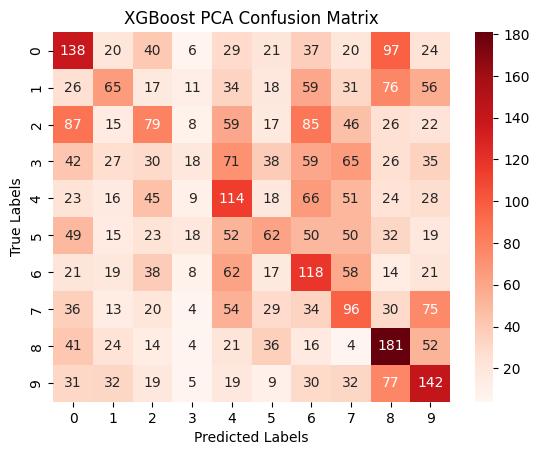

In [5]:
# confusion matrix
cm = confusion_matrix(y_test_new, y_pred_test_pca)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("XGBoost PCA Confusion Matrix")
plt.show()

In [9]:
le = LabelEncoder()
y_train_new = le.fit_transform(y_train)
y_test_new = le.transform(y_test)

rf = XGBClassifier(n_estimators=15, max_depth=6)

rf.fit(X_train, y_train_new)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
y_pred_train = rf.predict(X_train)
acc = accuracy_score(y_train_new, y_pred_train, normalize=True)
print(f'Accuracy for the train data is {acc*100:.2f}%')

y_pred_test = rf.predict(X_test)
acc = accuracy_score(y_test_new, y_pred_test, normalize=True)
print(f'Accuracy for the test data is {acc*100:.2f}%')

Accuracy for the train data is 86.19%
Accuracy for the test data is 43.73%


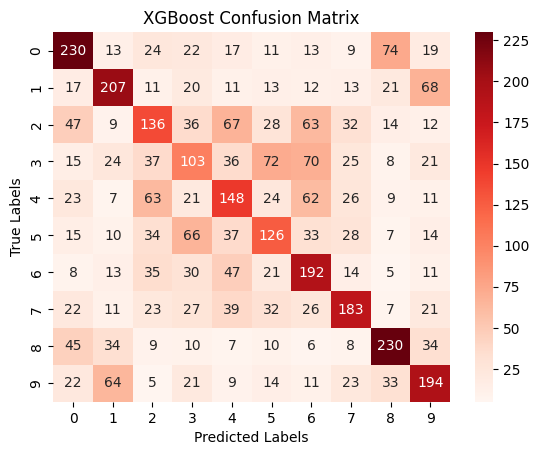

In [11]:
# confusion matrix
cm = confusion_matrix(y_test_new, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("XGBoost Confusion Matrix")
plt.show()